## Multilingual Language Classifier — End-to-End Notebook  

**This notebook demonstrates language classification tasks using the MASSIVE multilingual dataset.**
 
DATASET_LINK :  https://huggingface.co/datasets/qanastek/MASSIVE

```bash
00-Intro      │ imports
01-Config     │ language list & helper dicts
02-DataLoad   │ MASSIVE download & split to train/val/test
03-EDA        │ Plot of Train-set Samples,bar plots of sentence length, words counts
04-TrainLang  │ TF-IDF + MultinomialNB  
05-Evaluate   │ Confusion Matrix of Language (Validation_Set)
06-TrainCont  │ TF-IDF + SVD + LDA & QDA 
07-Visualize  │ ROC Curve for LDA & macro-accuracy on test split
08-SaveModels │ joblib.dump to artifacts/ (same paths as PredictPipeline)
09-QuickDemo  │ load pickles with your  PredictionPipeline() & SMOKE TEST
```

In [34]:
# Core imports
import os,json,sys,warnings
import joblib,pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

from pathlib import Path
from typing import List, Tuple

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_curve, auc)
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
                                          
warnings.filterwarnings("ignore")

In [3]:
# Setup directory and languages
massive_dataset = load_dataset("qanastek/MASSIVE", "en-US", split='test', trust_remote_code=True)
print(massive_dataset)
print(massive_dataset[0])

Dataset({
    features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'tokens', 'ner_tags', 'worker_id', 'slot_method', 'judgments'],
    num_rows: 2974
})
{'id': '0', 'locale': 'en-US', 'partition': 'test', 'scenario': 9, 'intent': 55, 'utt': 'wake me up at five am this week', 'annot_utt': 'wake me up at [time : five am] [date : this week]', 'tokens': ['wake', 'me', 'up', 'at', 'five', 'am', 'this', 'week'], 'ner_tags': [0, 0, 0, 0, 60, 16, 7, 37], 'worker_id': '1', 'slot_method': {'slot': [], 'method': []}, 'judgments': {'worker_id': [], 'intent_score': [], 'slots_score': [], 'grammar_score': [], 'spelling_score': [], 'language_identification': []}}


In [ ]:
# PATHS
ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(exist_ok=True)

In [6]:
# 27 Roman-script locales
LANGS: List[str] = [
    'af-ZA','da-DK','de-DE','en-US','es-ES','fr-FR','fi-FI','hu-HU','is-IS','it-IT',
    'jv-ID','lv-LV','ms-MY','nb-NO','nl-NL','pl-PL','pt-PT','ro-RO','ru-RU','sl-SL',
    'sv-SE','sq-AL','sw-KE','tl-PH','tr-TR','vi-VN','cy-GB'
]

In [ ]:
# locale → continent
continent_lookup = {
    'ZA':'Africa','KE':'Africa','AL':'Europe','GB':'Europe','DK':'Europe','DE':'Europe',
    'ES':'Europe','FR':'Europe','FI':'Europe','HU':'Europe','IS':'Europe','IT':'Europe',
    'ID':'Asia','LV':'Europe','MY':'Asia','NO':'Europe','NL':'Europe','PL':'Europe',
    'PT':'Europe','RO':'Europe','RU':'Europe','SL':'Europe','SE':'Europe','PH':'Asia',
    'TR':'Asia','VN':'Asia','US':'North America'
}

In [ ]:
def map_continent(locale:str)->str:
    return continent_lookup[locale.split('-')[1]] 

### **LOAD DATASET**

In [ ]:
# MASSIVE download & split to train/val/test

def load_massive_splits(locales:List[str])->Tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    """Loads train/validation/test once per locale (cached)."""
    
    buckets = {"train":[], "validation":[], "test":[]}
    for loc in locales:
        ds = load_dataset("qanastek/MASSIVE", loc, trust_remote_code=True)
        for split in buckets:
            tmp = pd.DataFrame(ds[split])[["utt"]].copy()
            tmp["locale"] = loc
            buckets[split].append(tmp)
            
    dfs = {k: pd.concat(v, ignore_index=True) for k,v in buckets.items()}

    for df in dfs.values():
        df["continent"] = df["locale"].apply(map_continent)
    return dfs["train"], dfs["validation"], dfs["test"]

In [10]:
# Load Data
print("🗃  Loading MASSIVE splits ... (first run may take ~2-3 min)")
train_df, val_df, test_df = load_massive_splits(LANGS)
print("Shapes:", train_df.shape, val_df.shape, test_df.shape)

🗃  Loading MASSIVE splits ... (first run may take ~2-3 min)
Shapes: (310878, 3) (54891, 3) (80298, 3)


### **EDA PLOTS**

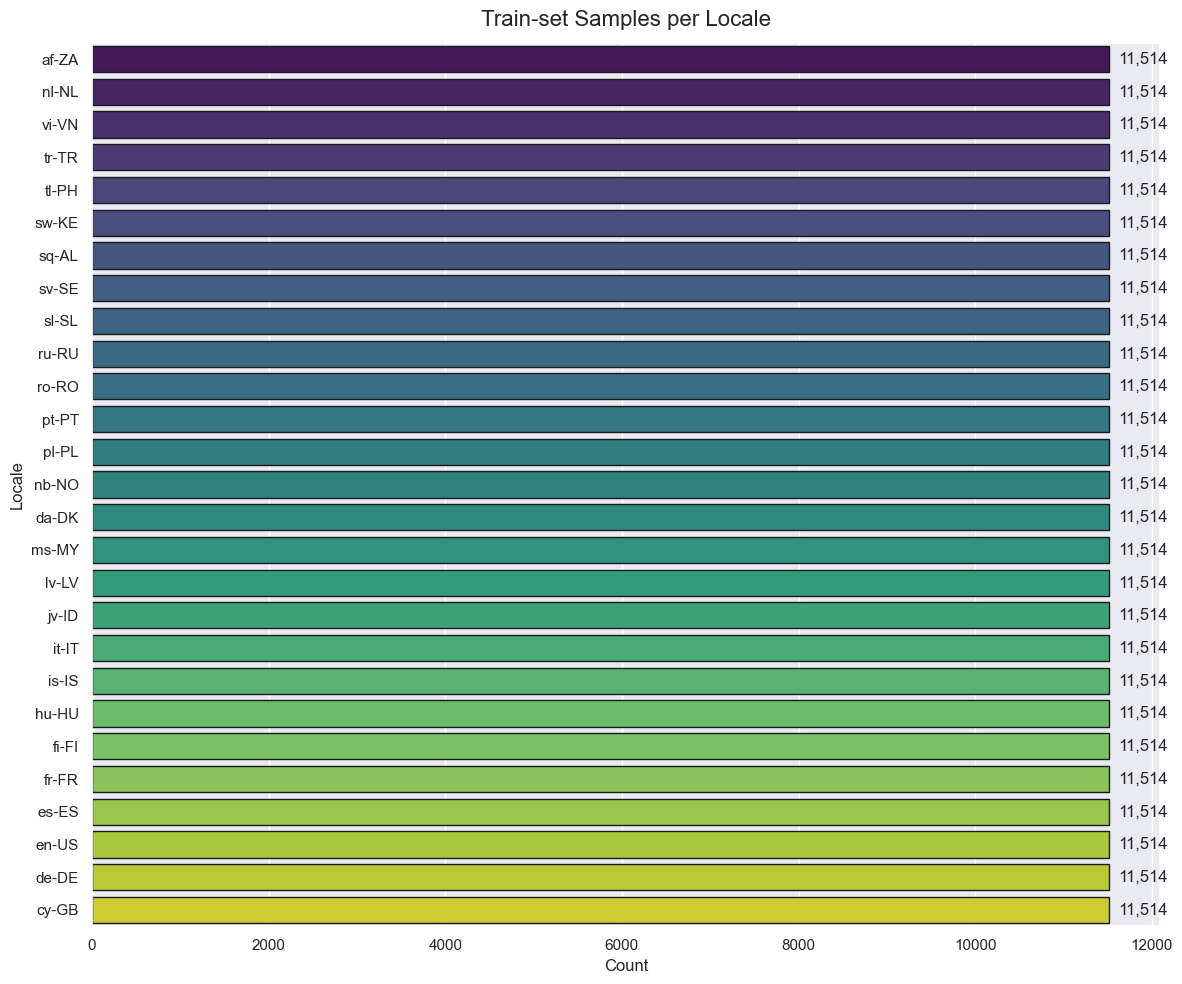

In [ ]:
# EDA PLOT #1 - Train-set Samples per Locale
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 10))

order = train_df["locale"].value_counts().index

sns.countplot(
    data=train_df,
    y="locale",
    order=order,
    ax=ax,
    palette="viridis",
    edgecolor="k"
)

ax.set_title("Train-set Samples per Locale", fontsize=16, pad=12)
ax.set_xlabel("Count")
ax.set_ylabel("Locale")

for p in ax.patches:
    w = p.get_width()
    ax.text(w + 100, p.get_y() + p.get_height()/2,
            f"{int(w):,}", va="center")

plt.tight_layout()
fig.savefig(ARTIFACTS / "samples_per_locale.png", dpi=300)
plt.show()


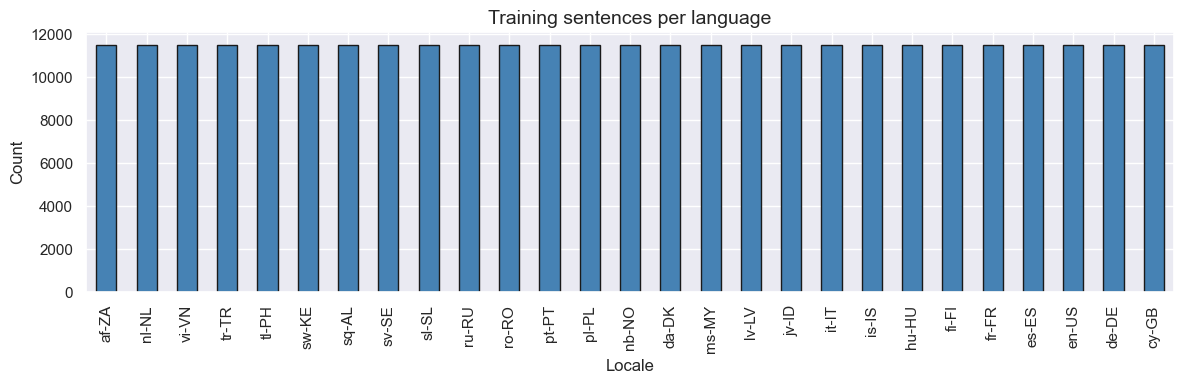

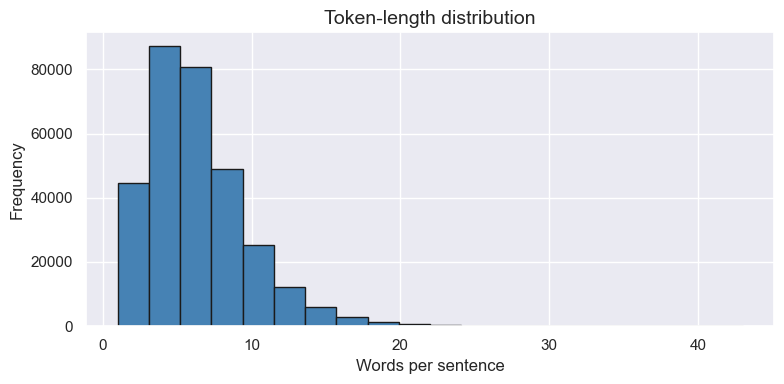

In [26]:
# EDA PLOT #2  – Training sentences per language  (bar)

fig2, ax = plt.subplots(figsize=(12, 4))
train_df["locale"].value_counts().plot(kind="bar", ax=ax, color="steelblue", edgecolor="k")
ax.set_title("Training sentences per language", fontsize=14)
ax.set_xlabel("Locale")
ax.set_ylabel("Count")
plt.tight_layout()
fig2.savefig(ARTIFACTS / "sentences_per_language.png", dpi=300)
plt.show()

# EDA PLOT #3  – Token-length distribution histogram

lens = train_df["utt"].str.split().apply(len)

fig3, ax = plt.subplots(figsize=(8, 4))
ax.hist(lens, bins=20, color="steelblue", edgecolor="k")
ax.set_title("Token-length distribution", fontsize=14)
ax.set_xlabel("Words per sentence")
ax.set_ylabel("Frequency")
plt.tight_layout()
fig3.savefig(ARTIFACTS / "words_per_sentence.png", dpi=300)
plt.show()


### **TRAINING MODEL**

In [47]:
# LANGUAGE MODEL

print("\n🔠 Training language classifier ...")
lang_pipe = make_pipeline(
    TfidfVectorizer(analyzer="char_wb", ngram_range=(1,3), max_features=10000),
    MultinomialNB(alpha=0.1))
lang_pipe.fit(train_df.utt, train_df.locale)

val_pred = lang_pipe.predict(val_df.utt)
test_pred= lang_pipe.predict(test_df.utt)

print("\n--- Naive Bayes Language Classification ---")
print("Validation Accuracy:", accuracy_score(val_df.locale,val_pred))
print("Test Accuracy:", accuracy_score(test_df.locale,test_pred))
print("Validation Report:")
print(classification_report(val_df.locale,val_pred))


print('----------------------------------')

print("Test Report:")
print(classification_report(test_df.locale, test_pred))



🔠 Training language classifier ...

--- Naive Bayes Language Classification ---
Validation Accuracy: 0.9686833907197901
Test Accuracy: 0.9698996239009688
Validation Report:
              precision    recall  f1-score   support

       af-ZA       0.93      0.95      0.94      2033
       cy-GB       0.99      0.99      0.99      2033
       da-DK       0.91      0.89      0.90      2033
       de-DE       0.97      0.97      0.97      2033
       en-US       0.90      0.97      0.94      2033
       es-ES       0.95      0.95      0.95      2033
       fi-FI       0.99      0.98      0.98      2033
       fr-FR       0.98      0.98      0.98      2033
       hu-HU       0.99      0.99      0.99      2033
       is-IS       1.00      0.99      0.99      2033
       it-IT       0.95      0.98      0.96      2033
       jv-ID       0.96      0.95      0.96      2033
       lv-LV       1.00      0.99      0.99      2033
       ms-MY       0.97      0.97      0.97      2033
       nb-NO   

### **Confusion Matrix**

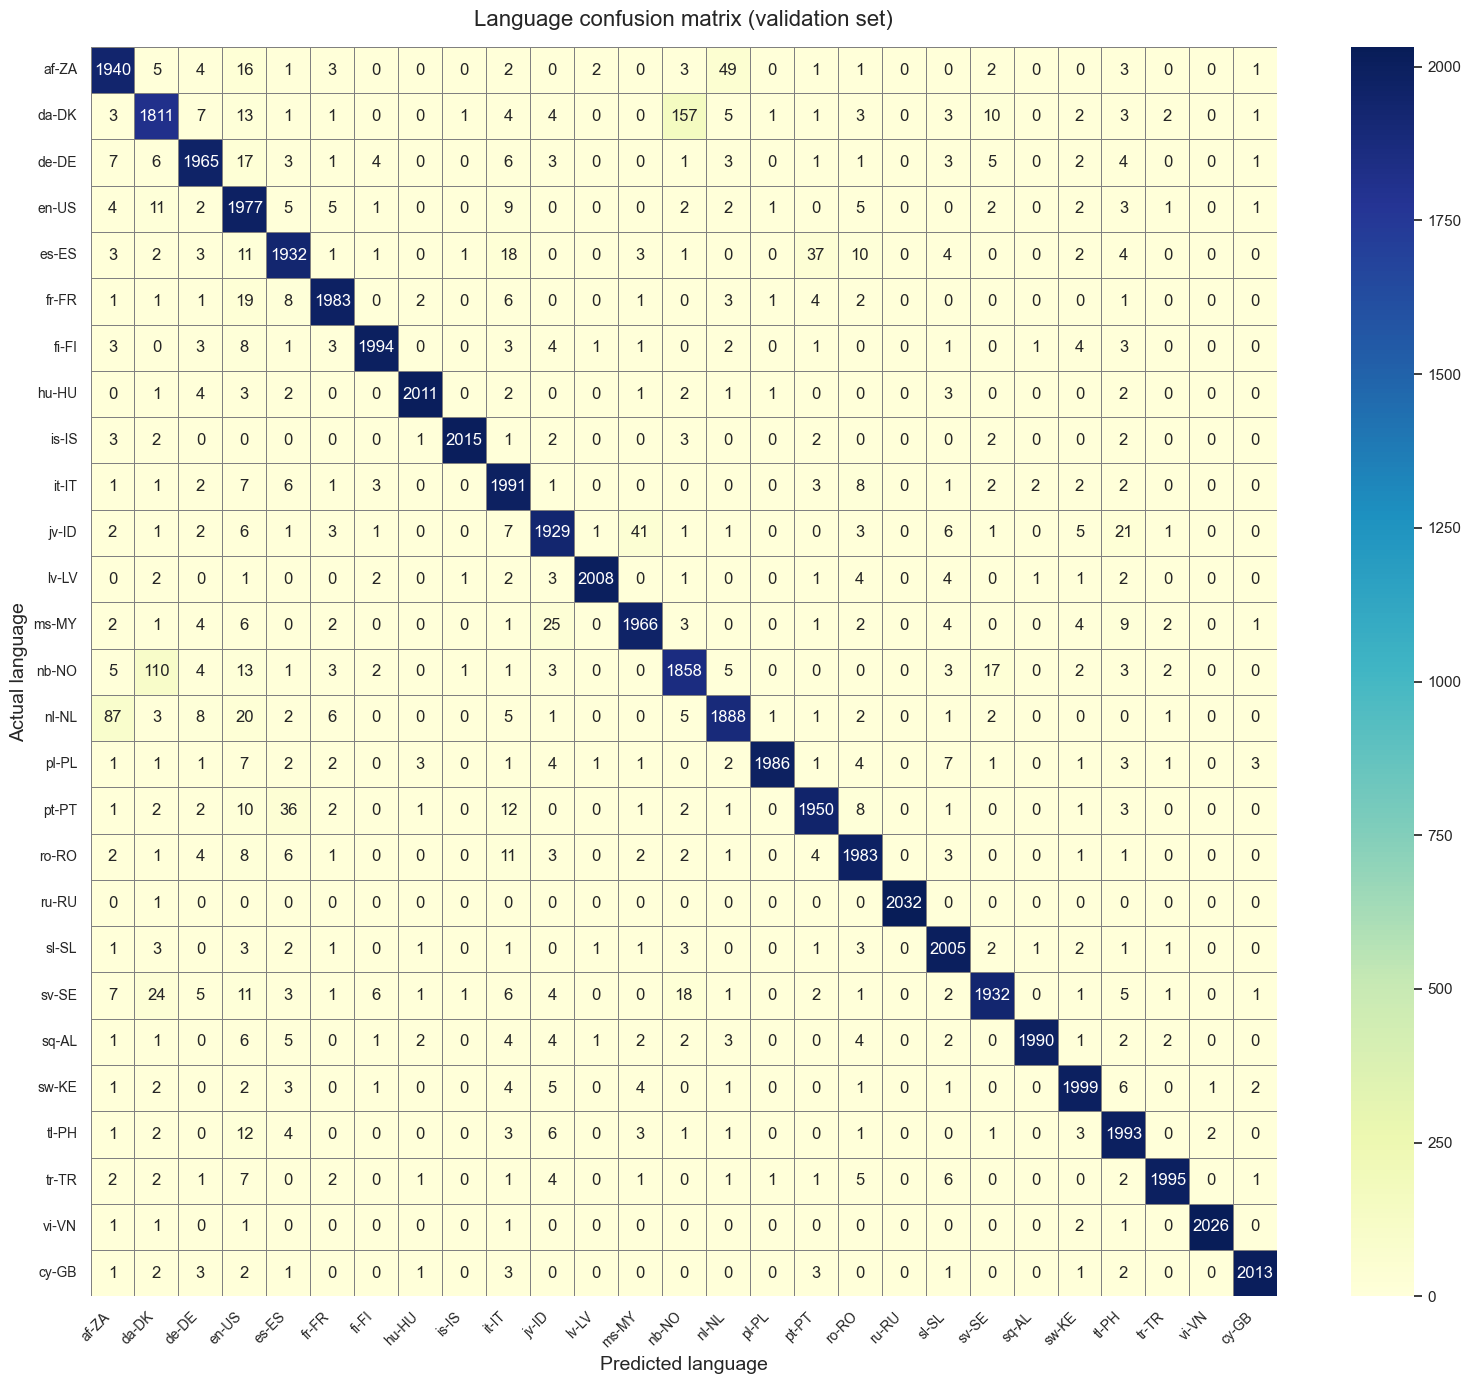

In [48]:
cm = confusion_matrix(val_df.locale, val_pred, labels=LANGS)
fig4, ax = plt.subplots(figsize=(16,14))
sns.heatmap(
    cm,
    annot=True,                   # show the count in each cell
    fmt="d",
    cmap="YlGnBu",                # light, readable colormap
    xticklabels=LANGS,
    yticklabels=LANGS,
    cbar=True,
    linewidths=0.5,
    linecolor="gray",
    ax=ax
)

ax.set_xlabel("Predicted language", fontsize=14)
ax.set_ylabel("Actual language", fontsize=14)
ax.set_title("Language confusion matrix (validation set)", fontsize=16, pad=15)

# rotate labels for visibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
fig4.savefig(ARTIFACTS / "lang_confusion.png", dpi=300)
plt.show()

In [49]:
# CONTINENT MODEL 

print("\n🌍 Training continent classifier ...")
vec = TfidfVectorizer(max_features=15000)
X_train = vec.fit_transform(train_df.utt)
X_val   = vec.transform(val_df.utt)
X_test  = vec.transform(test_df.utt)

svd = TruncatedSVD(n_components=100, random_state=42)
X_train_r = svd.fit_transform(X_train)
X_val_r   = svd.transform(X_val)
X_test_r  = svd.transform(X_test)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_r, train_df.continent)
val_lda = lda.predict(X_val_r)
test_lda = lda.predict(X_test_r)


qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_r, train_df.continent)
val_qda = qda.predict(X_val_r)
test_qda = qda.predict(X_test_r)


print("\n--- LDA Continent Classification ---")
print("LDA Validation Accuracy:", accuracy_score(val_df.continent, val_lda ))
print("LDA Test Accuracy      :", accuracy_score(test_df.continent, test_lda))
print("\n",classification_report(val_df.continent, val_lda))


print('----------------------------------')
print("\n--- QDA Continent Classification ---")
print("QDA Validation Accuracy:", accuracy_score(val_df.continent,val_qda ))
print("QDA Test Accuracy     :", accuracy_score(test_df.continent, test_qda))
print("\n",classification_report(val_df.continent, val_qda))


🌍 Training continent classifier ...

--- LDA Continent Classification ---
LDA Validation Accuracy: 0.8940809968847352
LDA Test Accuracy      : 0.8902587860220678

                precision    recall  f1-score   support

       Africa       0.88      0.69      0.78      4066
         Asia       0.99      0.67      0.80     10165
       Europe       0.88      0.99      0.93     38627
North America       0.86      0.67      0.76      2033

     accuracy                           0.89     54891
    macro avg       0.91      0.75      0.82     54891
 weighted avg       0.90      0.89      0.89     54891

----------------------------------

--- QDA Continent Classification ---
QDA Validation Accuracy: 0.8168916580131533
QDA Test Accuracy     : 0.8117014122394082

                precision    recall  f1-score   support

       Africa       0.64      0.94      0.76      4066
         Asia       0.77      0.93      0.84     10165
       Europe       0.99      0.76      0.86     38627
North Ame

### **ROC CURVE**

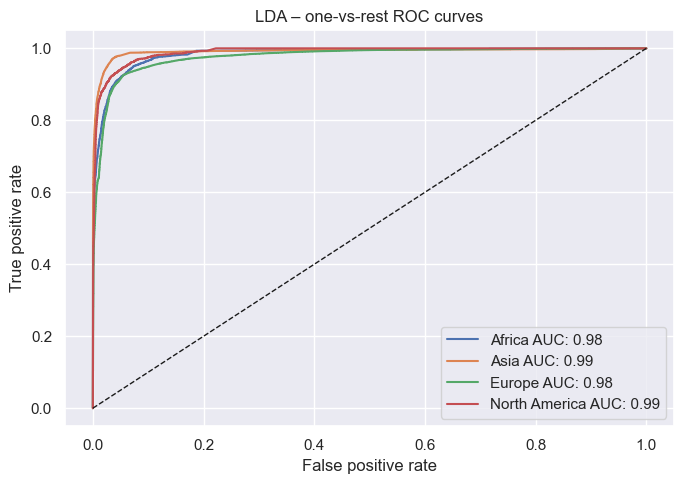

In [50]:
#  ROC curve for LDA (one-vs-rest) 

classes = ["Africa", "Asia", "Europe", "North America"]

# keyword-only arg in sklearn ≥1.4
y_val_bin = label_binarize(val_df.continent, classes=classes)
y_score   = lda.predict_proba(X_val_r)

fig5, ax = plt.subplots(figsize=(7, 5))
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    ax.plot(fpr, tpr, label=f"{c} AUC: {auc(fpr, tpr):.2f}")

ax.plot([0, 1], [0, 1], "k--", lw=1)
ax.set_title("LDA – one-vs-rest ROC curves")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.legend(loc="lower right")
plt.tight_layout()

fig5.savefig(ARTIFACTS / "lda_roc.png", dpi=300)
plt.show()


### **ARTIFACTS**

In [ ]:
# SAVE ARTIFACTS 
print("\n💾 Saving artefacts to 'artifacts/' ...")
joblib.dump(lang_pipe,          ARTIFACTS/"language_pipeline.pkl")
joblib.dump(vec,                ARTIFACTS/"continent_vectorizer.pkl")
joblib.dump(svd,                ARTIFACTS/"continent_svd.pkl")
joblib.dump(lda,                ARTIFACTS/"continent_lda_model.pkl")
joblib.dump(qda,                ARTIFACTS/"continent_qda_model.pkl")


💾 Saving artefacts to 'artifacts/' ...


['artifacts\\continent_qda_model.pkl']

In [35]:
# Label encoder for continents

le = LabelEncoder().fit(classes)
joblib.dump(le, ARTIFACTS/"continent_label_encoder.pkl")

perf = {
    "language_val_acc": float(accuracy_score(val_df.locale,val_pred)),
    "language_test_acc": float(accuracy_score(test_df.locale,test_pred)),
    "continent_val_acc": float(accuracy_score(val_df.continent, lda.predict(X_val_r))),
    "continent_test_acc": float(accuracy_score(test_df.continent, lda.predict(X_test_r)))
}
with open(ARTIFACTS/"model_performance.pkl","wb") as f: pickle.dump(perf,f)

### **SMOKE TEST**

In [51]:
#  SMOKE TEST 
print("\n🚦 Reloading pickles for smoke-test ...")
lang_pipe2 = joblib.load(ARTIFACTS/"language_pipeline.pkl")
lda2       = joblib.load(ARTIFACTS/"continent_lda_model.pkl")
vec2       = joblib.load(ARTIFACTS/"continent_vectorizer.pkl")
svd2       = joblib.load(ARTIFACTS/"continent_svd.pkl")
le2        = joblib.load(ARTIFACTS/"continent_label_encoder.pkl")

print("Reloaded language test acc:",
      accuracy_score(test_df.locale, lang_pipe2.predict(test_df.utt)).round(4))
X_test_r2 = svd2.transform(vec2.transform(test_df.utt))
print("Reloaded LDA continent test acc:",
      accuracy_score(test_df.continent, lda2.predict(X_test_r2)).round(4))

samples = ["Hello how are you?",
           "Bonjour, comment ça va?",
           "Guten Tag, wie geht's?"]


print('----------------------------------')
print("\nSample predictions:")

for s in samples:
    lang_pred = lang_pipe2.predict([s])
    cont_pred = lda.predict(svd.transform(vec.transform([s])))
    # cont_pred is already string labels: ['Europe']
    print(f"  '{s[:25]}...' ➜ {lang_pred} / {cont_pred}")


print("Done ✅")


🚦 Reloading pickles for smoke-test ...
Reloaded language test acc: 0.9699
Reloaded LDA continent test acc: 0.8903
----------------------------------

Sample predictions:
  'Hello how are you?...' ➜ ['en-US'] / ['Europe']
  'Bonjour, comment ça va?...' ➜ ['fr-FR'] / ['Europe']
  'Guten Tag, wie geht's?...' ➜ ['de-DE'] / ['Europe']
Done ✅


### **Large_Pickle_Files_Solution**
- If Pickles Files are Large then we can't upload in github repo for deployment.
- Upload on Google Drive or Kaggle and fetch from there.
- Below define the structure, how to proceed.


In [ ]:
import os

def download_from_kaggle():
    import streamlit as st
    from kaggle.api.kaggle_api_extended import KaggleApi

    # Save kaggle.json from Streamlit secrets
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")
    with open(kaggle_json_path, "w") as fp:
        fp.write(st.secrets["KAGGLE_JSON"])
    os.chmod(kaggle_json_path, 0o600)

    # Download files
    api = KaggleApi()
    api.authenticate()
    st.info("Downloading Kaggle dataset artifacts if not already present...")
    api.dataset_download_files(
        "sonalikasingh17/massive-pickle-files",
        path="artifacts",
        unzip=True
    )
    st.success("Kaggle artifacts downloaded and ready.")


    def ensure_artifacts_exist():
    # Only download if needed
        important_files = [
            "language_pipeline.pkl",
            "continent_lda_model.pkl",
            "continent_qda_model.pkl",
            "continent_vectorizer.pkl",
            "continent_svd.pkl",
            "continent_label_encoder.pkl",
        ]
        missing = [f for f in important_files if not os.path.exists(os.path.join("artifacts", f))]
        if missing:
        download_from_kaggle()



# def ensure_artifacts_exist():
#     """Download all .pkl files from the Kaggle dataset once."""
#     KAGGLE_BASE = (
#         "https://www.kaggle.com/datasets/"
#         "sonalikasingh17/massive-pickle-files/download?file="
#     )
#     artifact_files = [
#         # language pipeline  (for fast inference)
#         "language_pipeline.pkl",
#         # continent models
#         "continent_lda_model.pkl",
#         "continent_qda_model.pkl",
#         # vectorisers / reducers
#         "continent_vectorizer.pkl",
#         "continent_svd.pkl",
#         # label encoders
#         "continent_label_encoder.pkl",
#         "label_encoder.pkl",
#         # optional extras
#         "language_model.pkl",
#         "language_vectorizer.pkl",
#         "model_performance.pkl"
#     ]

#     os.makedirs("artifacts", exist_ok=True)

#     for fname in artifact_files:
#         path = os.path.join("artifacts", fname)
#         if os.path.exists(path):
#             continue                                 

#         # user feedback (works both in Streamlit & CLI)
#         try:
#             st.info(f"Downloading {fname} from Kaggle…")
#         except Exception:
#             print(f"[INFO] Downloading {fname}")

#         url = KAGGLE_BASE + fname
#         with requests.get(url, stream=True) as r:
#             r.raise_for_status()
#             with open(path, "wb") as f:
#                 for chunk in r.iter_content(chunk_size=8192):
#                     f.write(chunk)

#         try:
#             st.success(f"Downloaded {fname}")
#         except Exception:
#             print(f"[INFO] Downloaded {fname}")
